In [2]:
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle
import json
import math

import chess.gaviota as gaviota

keras.config.enable_unsafe_deserialization()

In [3]:
gaviota_folder = r"C:\SPEICHER\Bachelor_Thesis\Gaviota"

In [4]:
def get_model_acc(X1, X2, y, model_type, model=None, model_pro=None, threshold1 = 0, threshold2 = 0):
    if model_type == "single":
        y1 = model.predict(X1,verbose=0)
        y2 = model.predict(X2,verbose=0)
        y_pred = np.where(np.abs(y1 - y2) < threshold1, 0, np.where(y1 > y2, 1, 2))
        y_combined = np.hstack([y1, y2])
        y_pred_pro = np.argmax(model_pro.predict(y_combined,verbose=0), axis=1)
        return accuracy_score(y, y_pred), accuracy_score(y, y_pred_pro)
    
    elif model_type == "regression":
        y_pred = model.predict([X1, X2],verbose=0)
        y_pred_th = np.where(y_pred > threshold2, 2, np.where(y_pred < threshold1, 1, 0))
        y_pred_pro = np.argmax(model_pro.predict(y_pred,verbose=0), axis=1)
        return accuracy_score(y, y_pred_th), accuracy_score(y, y_pred_pro)
    
    elif model_type == "classification":
        y_pred = np.argmax(model.predict([X1, X2],verbose=0), axis=1)
        return confusion_matrix(y, y_pred), accuracy_score(y, y_pred)

In [5]:
endgame = "Mixed"
model_types = ["single", "regression", "classification"]
cm = {}
histories = {}
accuracies = {}

with open(r"C:\SPEICHER\Bachelor_Thesis\Experiments\Configs\Mixed_thresholds.json", "r") as f:
    threshold_config = json.load(f)

accuracies[endgame] = {}
data = np.load(fr"C:\SPEICHER\Bachelor_Thesis\Experiments\DataBase\{endgame}_position_test.npz")
positions, dtm_values = data["X"], data["y"]
data = np.load(fr"C:\SPEICHER\Bachelor_Thesis\Experiments\DataBase\{endgame}_pairs_test.npz")
X1, X2, y = data["X1"], data["X2"], data["y"]
temp_hist_list = []
for model_type in model_types:
    model = keras.models.load_model(fr"C:\SPEICHER\Bachelor_Thesis\Experiments\Models\{endgame}_model_{model_type}.keras")
    if not model_type == "classification":
        model_pro = keras.models.load_model(fr"C:\SPEICHER\Bachelor_Thesis\Experiments\Models\{endgame}_model_pro_{model_type}.keras")
        threshold1, threshold2 = threshold_config[endgame][model_type]["threshold1"], threshold_config[endgame][model_type]["threshold2"]
    
    model_acc, model_pro_acc = get_model_acc(X1, X2, y, model_type, model, model_pro if not model_type=="classification" else None, threshold1=threshold1, threshold2=threshold2)
    
    if model_type == "classification":
        cm[endgame] = model_acc
        accuracies[endgame][model_type] = model_pro_acc
    else:
        accuracies[endgame][model_type] = (model_acc, model_pro_acc)
    with open(fr"C:\SPEICHER\Bachelor_Thesis\Experiments\Histories\{endgame}_history_{model_type}.pkl", "rb") as f:
        temp_hist_list.append(pickle.load(f))

histories[endgame] = temp_hist_list

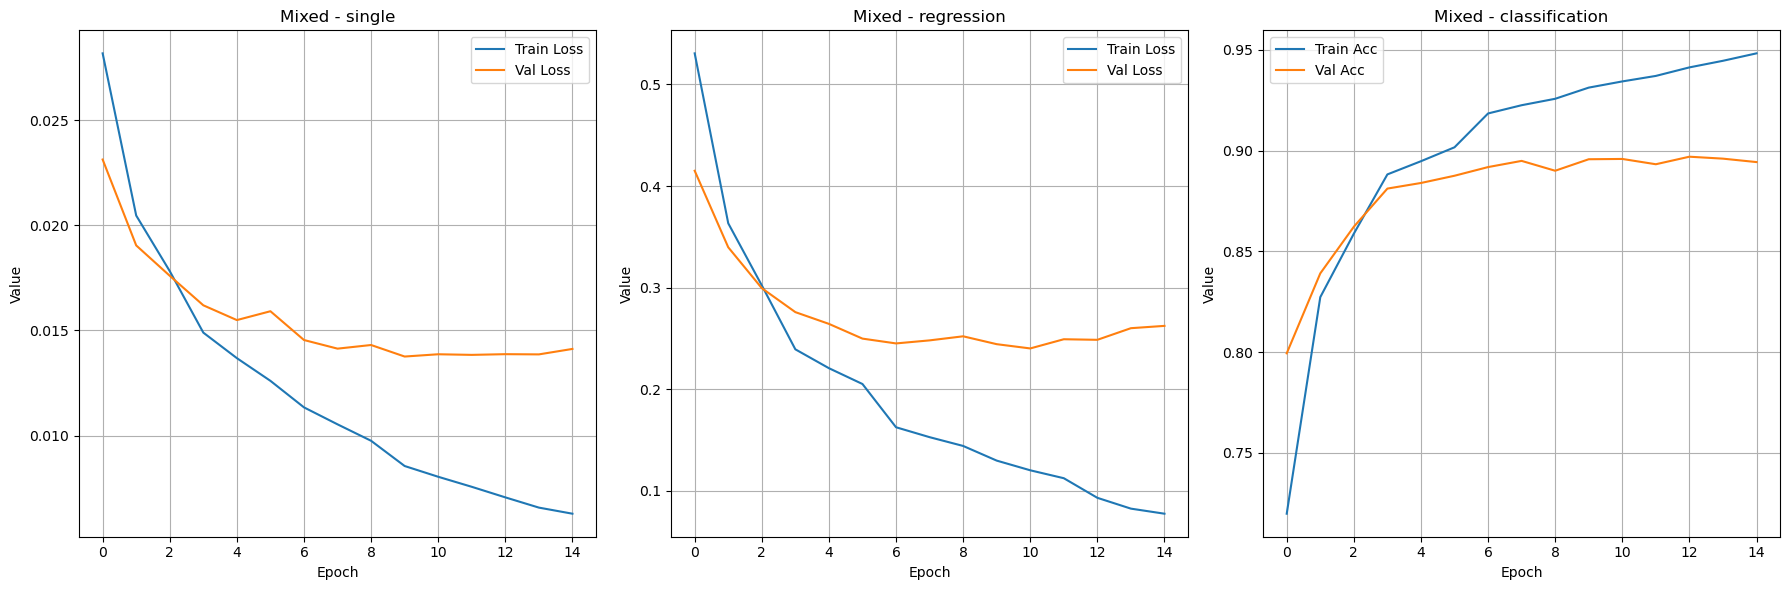

In [6]:
num_endgames = 1
num_models = len(model_types)

fig, axes = plt.subplots(num_endgames, num_models, figsize=(6 * num_models, 6 * num_endgames))

for row_idx, endgame in enumerate([endgame]):
    for col_idx, model_type in enumerate(model_types):
        hist = histories[endgame][col_idx]
        ax = axes[row_idx, col_idx] if num_endgames > 1 else axes[col_idx]
        
        if 'accuracy' in hist:
            ax.plot(hist['accuracy'], label='Train Acc')
            ax.plot(hist['val_accuracy'], label='Val Acc')
        else:
            ax.plot(hist['loss'], label='Train Loss')
            ax.plot(hist['val_loss'], label='Val Loss')

        ax.set_title(f"{endgame} - {model_type}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Value")
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()

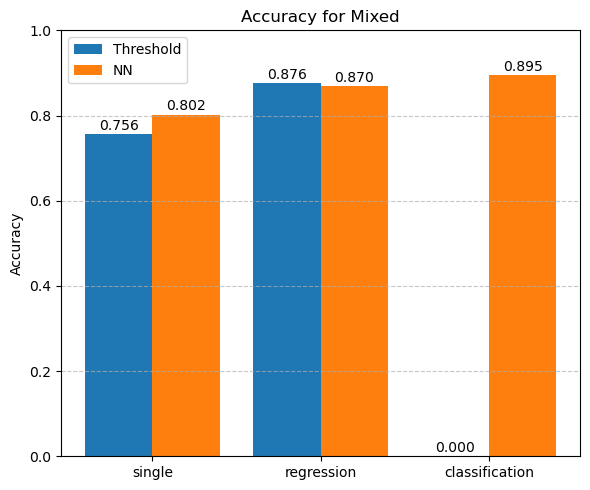

In [7]:
endgames = [endgame]
fig, axes = plt.subplots(1, len(endgames), figsize=(6 * len(endgames), 5))

if len(endgames) == 1:
    axes = [axes]  # ensure it's iterable

for idx, endgame in enumerate(endgames):
    ax = axes[idx]
    model_names = []
    accuracy_scores = []
    pro_accuracy_scores = []

    for i, model_type in enumerate(model_types):
        acc_pair = accuracies[endgame][model_type]
        model_names.append(model_type)
        if type(acc_pair) is tuple:
            pro_accuracy_scores.append(acc_pair[1])
            accuracy_scores.append(acc_pair[0])
        else:
            accuracy_scores.append(0)
            pro_accuracy_scores.append(acc_pair)
        

    x = range(len(model_names))
    ax.bar(x, accuracy_scores, width=0.4, label="Threshold", align='center')
    ax.bar([i + 0.4 for i in x], pro_accuracy_scores, width=0.4, label="NN", align='center')

    ax.set_xticks([i + 0.2 for i in x])
    ax.set_xticklabels(model_names)
    ax.set_ylim(0, 1)
    ax.set_title(f"Accuracy for {endgame}")
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    for j in range(len(model_names)):
        ax.text(j, accuracy_scores[j] + 0.01, f'{accuracy_scores[j]:.3f}', ha='center')
        ax.text(j + 0.4, pro_accuracy_scores[j] + 0.01, f'{pro_accuracy_scores[j]:.3f}', ha='center')

plt.tight_layout()
plt.show()

Endgame: Mixed
Class Equal Accuracy: 0.8280
Class Pos1 better Accuracy: 0.9153
Class Pos2 better Accuracy: 0.9012


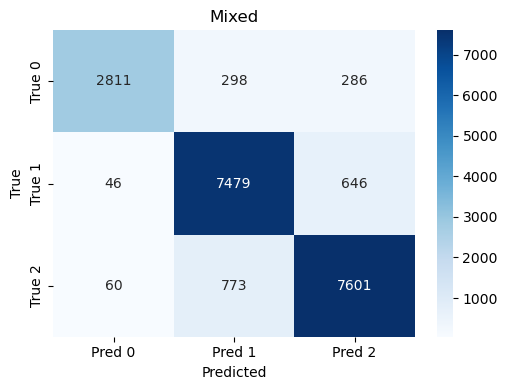

In [8]:
# Create a grid layout for subplots
n = len(cm)
cols = 2  # e.g. 3 plots per row
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))

# Flatten axes for easy indexing
axes = axes.flatten()

class_labels = ["Equal", "Pos1 better", "Pos2 better"]

for i, (endgame_name, confusion_matrix) in enumerate(cm.items()):
    ax = axes[i]
    print(F"Endgame: {endgame_name}")
    # Print results with class labels
    for label, acc in zip(class_labels, (confusion_matrix.diagonal() / confusion_matrix.sum(axis=1))):
        print(f"Class {label} Accuracy: {acc:.4f}")
    # Plot heatmap in subplot
    sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[f"Pred {j}" for j in range(3)],
        yticklabels=[f"True {j}" for j in range(3)],
        ax=ax
    )
    ax.set_title(f"{endgame_name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


**EXAMPLE**

In [9]:
import chess
import chess.gaviota

def encode_position(board: chess.Board, additional_pieces: list) -> np.ndarray:
    # additional_pieces e.g. [(chess.ROOK, chess.WHITE), (chess.PAWN, chess.BLACK)]
    def getRowCol(pos):
        return 7 - (pos // 8), pos % 8 # White is at the bottom, so we invert the row index
    
    # Fixed 6 channels: King (0), Queen (1), Rook (2), Bishop (3), Knight (4), Pawn (5)
    representation = np.zeros((6, 8, 8), dtype=np.int8)

    # Kings (Channel 0)
    white_king_pos = board.king(chess.WHITE)
    if white_king_pos is not None:
        representation[0, *getRowCol(white_king_pos)] = 1
    black_king_pos = board.king(chess.BLACK)
    if black_king_pos is not None:
        representation[0, *getRowCol(black_king_pos)] = -1

    # Map piece types to their fixed channels
    piece_to_channel = {
        chess.QUEEN: 1,
        chess.ROOK: 2,
        chess.BISHOP: 3,
        chess.KNIGHT: 4,
        chess.PAWN: 5
    }

    # Place additional pieces in their designated channels
    for piece_type, color in additional_pieces:
        if piece_type in piece_to_channel:
            channel = piece_to_channel[piece_type]
            squares = board.pieces(piece_type, color)
            for square in squares:
                representation[channel, *getRowCol(square)] = 1 if color == chess.WHITE else -1

    return representation

In [10]:
def standardize_board(board):
    has_pawn = bool(board.pawns)

    if board.turn == chess.BLACK:
        board = board.copy()
        # Swap colors for all pieces
        for square, piece in board.piece_map().items():
            board.set_piece_at(square, chess.Piece(piece.piece_type, not piece.color))
        board.turn = chess.WHITE  # Ensure White always moves first

    wk_square = board.king(chess.WHITE)
    wk_rank, wk_file = divmod(wk_square, 8)

    # If White King is already in the correct triangle, return as is
    if 0 <= wk_rank <= 3 and 4 <= wk_file <= 7 and wk_rank + wk_file <= 7:
        return board.copy()
    
    # Transformation functions
    def rotate_180(square): return chess.square(7 - square % 8, 7 - square // 8)
    def mirror_vertical(square): return chess.square(7 - square % 8, square // 8)
    def mirror_diagonal(square): return chess.square(7 - square // 8, 7 - square % 8)

    # Apply transformation based on white king position (only vertical mirror if pawns present)
    transform = None
    if has_pawn:
        if 0 <= wk_rank <= 7 and 0 <= wk_file <= 3:  # Left half → mirror vertically
            transform = mirror_vertical
    else:
        if 0 <= wk_rank <= 3 and 0 <= wk_file <= 3:  # Bottom-left → mirror vertically
            transform = mirror_vertical
        elif 4 <= wk_rank <= 7 and 0 <= wk_file <= 3:  # Top-left → rotate 180
            transform = rotate_180
        elif 4 <= wk_rank <= 7 and 4 <= wk_file <= 7:  # Top-right → mirror horizontally
            transform = lambda x: mirror_diagonal(rotate_180(x))  # Horizontal = diagonal + 180
        elif wk_rank + wk_file > 7:  # Outside triangle → mirror diagonally
            transform = mirror_diagonal

    # Apply transformation if needed
    if transform:
        new_board = chess.Board.empty()
        new_board.turn = chess.WHITE
        for square, piece in board.piece_map().items():
            new_board.set_piece_at(transform(square), piece)
        board = new_board

    # If no pawns, ensure black king or other pieces are on the correct side of the diagonal
    if not has_pawn:
        wk_square = board.king(chess.WHITE)
        wk_rank, wk_file = divmod(wk_square, 8)
        if wk_rank == wk_file:  # White king on diagonal
            for piece_type in [chess.KING, chess.ROOK, chess.QUEEN]:
                square = next((s for s, p in board.piece_map().items() if p.piece_type == piece_type and p.color == chess.BLACK), None)
                if square:
                    rank, file = divmod(square, 8)
                    if rank + file > 7:  # Piece on wrong side of diagonal
                        new_board = chess.Board.empty()
                        new_board.turn = chess.WHITE
                        for sq, piece in board.piece_map().items():
                            new_square = mirror_diagonal(sq) if piece == board.piece_at(square) else sq
                            new_board.set_piece_at(new_square, piece)
                        board = new_board
                        break

    return board

In [11]:
# Helper to get additional pieces from a board
def get_additional_pieces(board):
    pieces = set()
    for piece in board.piece_map().values():
        if piece.piece_type != chess.KING:  # Exclude kings
            pieces.add((piece.piece_type, piece.color))
    return sorted(list(pieces))  # Sort for consistency

In [12]:
def prediction(position1, position2, model, model_type, threshold1=None, threshold2=None, model_pro=None):
    board1 = standardize_board(chess.Board(position1))
    board2 = standardize_board(chess.Board(position2))
    additional_pieces1 = get_additional_pieces(board1)
    additional_pieces2 = get_additional_pieces(board2)

    X1 = np.expand_dims(encode_position(board1, additional_pieces1),axis=0)
    X2 = np.expand_dims(encode_position(board2, additional_pieces2),axis=0)

    if model_type == "single":
        y1 = model.predict(X1, verbose=0)
        y2 = model.predict(X2, verbose=0)
        y_pred = np.where(np.abs(y1-y2)<threshold1, 0, np.where(y1>y2,1,2))
        y_pred_pro = np.argmax(model_pro.predict(np.hstack([y1,y2]), verbose=0))
        return y_pred.item(), y_pred_pro.item()
    elif model_type == "regression":
        y = model.predict([X1, X2], verbose=0)
        y_pred = np.where(y > threshold2, 2, np.where(y < threshold1, 1, 0))
        y_pred_pro = np.argmax(model_pro.predict(y, verbose=0))
        return y_pred.item(), y_pred_pro.item()
    elif model_type == "classification":
        y_pred = np.argmax(model.predict([X1, X2], verbose=0))
        return y_pred

In [13]:
def print_position_comparison(dtm1, dtm2):
    if dtm1:
        dtm1 = 1/dtm1
    if dtm2:
        dtm2 = 1/dtm2
    
    output_string = "Database: "
    
    if dtm1>dtm2:
        output_string += "Position 1 is better than Position 2!"
    elif dtm2 > dtm1:
        output_string += "Position 2 is better than Position 1!"
    elif dtm1==dtm2:
        output_string += "Positions are equally good!"

    return output_string

def helper(wdl, dtm):
    return f"{'win' if wdl == 1 else 'draw' if wdl==0 else 'lose'} in {abs(dtm)} moves."

def comparison_tablebase(position1, position2):
  
    with gaviota.open_tablebase(gaviota_folder) as tablebase:
        # Creating boards for the positions
        board1 = chess.Board(position1)
        board2 = chess.Board(position2)

        # Position 1
        wdl1 = tablebase.probe_wdl(board1)
        dtm1 = tablebase.probe_dtm(board1)

        # Position 2
        wdl2 = tablebase.probe_wdl(board2)
        dtm2 = tablebase.probe_dtm(board2)
        
        output_string = print_position_comparison(dtm1, dtm2)
        output_string += f" [Position 1: {'White' if board1.turn else 'Black'} to move and {helper(wdl1, dtm1)} "
        output_string += f"Position 2: {'White' if board1.turn else 'Black'} to move and {helper(wdl2, dtm2)}]"
        print(output_string)

In [14]:
def make_prediction(value):
    if type(value) == tuple:
        return make_prediction(value[0])+" Pro model: " + make_prediction(value[1])
    if value==0:
        return "Positions are equal!"
    return f"Position {value} is better!"

In [15]:
pos2 = "4k3/8/3p4/8/q7/4N3/8/4K3 w - - 0 1"

In [16]:
pos1 = "8/8/3k3p/8/6q1/4N3/8/5K2 w - - 0 1"

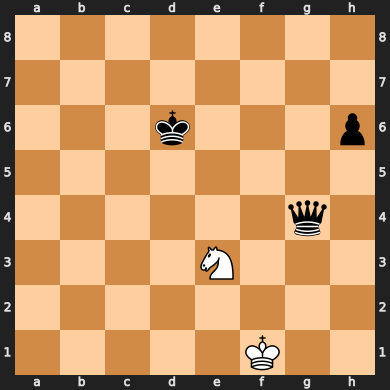

In [17]:
chess.Board(pos1)

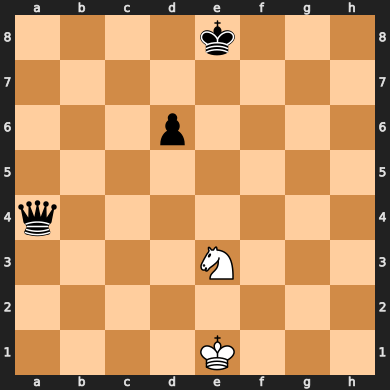

In [18]:
chess.Board(pos2)

In [19]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
model_types = ["single", "regression", "classification"]
results = {}

with open(r"Configs\Mixed_thresholds.json", "r") as f:
    threshold_config = json.load(f)

print(f"\n=== Endgame: {endgame} ===")
print("For the player to move the following is expected")
comparison_tablebase(pos1, pos2)
results[endgame] = {}

for model_type in model_types:
    # Load base model
    model_path = fr"Models\{endgame}_model_{model_type}.keras"
    model = keras.models.load_model(model_path)

    # Load pro model and thresholds if necessary
    model_pro = None
    threshold1, threshold2 = None, None
    if model_type != "classification":
        model_pro_path = fr"Models\{endgame}_model_pro_{model_type}.keras"
        model_pro = keras.models.load_model(model_pro_path)
        threshold1 = threshold_config[endgame][model_type]["threshold1"]
        threshold2 = threshold_config[endgame][model_type]["threshold2"]

    # Run prediction
    try:
        pred = prediction(pos1, pos2, model, model_type, threshold1, threshold2, model_pro)
    except Exception as e:
        pred = f"Error: {e}"

    # Store and print result
    results[endgame][model_type] = pred
    print(f"{model_type.capitalize()} Model: {make_prediction(pred)}")


=== Endgame: Mixed ===
For the player to move the following is expected
Database: Position 1 is better than Position 2! [Position 1: White to move and draw in 0 moves. Position 2: White to move and lose in 26 moves.]
Single Model: Position 2 is better! Pro model: Position 2 is better!
Regression Model: Position 2 is better! Pro model: Position 2 is better!
Classification Model: Position 1 is better!
